The goal of this notebook is to load pre-processed carbon stock datasets, standardize units and spatial resolution, and mosaic together into layers that provide wall-to-wall carbon stock metrics for the y2y region.

In [1]:
# load packages
import geopandas as gpd
import rasterio
from rasterio.warp import Resampling
import rioxarray
import xarray
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

In [2]:
# define print raster function to help compare reprojections
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
        f"NoDataValue: {raster.rio.nodata}\n"
        f"NoDataOriginalValues: {raster.rio.encoded_nodata}\n"
    )

### The first map is a combination of Sothe forest carbon canada layers and Spawn agb/bgb CONUS Forest Carbon Stock layers.

In [3]:
# set clipped layers directory
carbon_dir = './carbon_stock_data/final_layers_clipped'

# set Sothe carbon stock layers filepaths
carbon_sothe_dir = carbon_dir + '/forest_carbon_kg_m2_sothe.tif'

# set spawn carbon stock layers filepaths
agb_spawn_dir = carbon_dir + '/agb_mg_ha_spawn_2010.tif'
bgb_spawn_dir = carbon_dir + '/bgb_mg_ha_spawn_2010.tif'

In [4]:
# load data arrays
carbon_sothe = xarray.open_dataarray(carbon_sothe_dir)
agb_spawn = xarray.open_dataarray(agb_spawn_dir)
bgb_spawn = xarray.open_dataarray(bgb_spawn_dir)

In [5]:
# print attributes
print_raster(carbon_sothe)
print_raster(agb_spawn)
print_raster(bgb_spawn)

shape: (11385, 14576)
resolution: (0.00224599624135848, -0.0022459534258844607)
bounds: (-141.03574267575004, 41.75148751365874, -108.29810146170884, 67.32166726735333)
sum: 100289472.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -3.4028234663852886e+38

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 8712377344.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 3599774464.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0



In [6]:
# add spawn agb and bgb together
carbon_spawn = agb_spawn + bgb_spawn

# print attributes
print_raster(carbon_spawn)


shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: None
NoDataOriginalValues: None



In [7]:
# reproject sothe to match spawn projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
carbon_sothe_reproj = carbon_sothe.rio.reproject_match(carbon_spawn, resampling=Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)

# assign coords to make coordinates the exact same (can be tiny differences)
carbon_sothe_reproj = carbon_sothe_reproj.assign_coords({
    "x": carbon_spawn.x,
    "y": carbon_spawn.y,
})

In [8]:
# print attributes
print_raster(carbon_sothe_reproj)
print_raster(carbon_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 66024460.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -3.4028234663852886e+38

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 12312211456.0
CRS: EPSG:4326
NoDataValue: None
NoDataOriginalValues: None



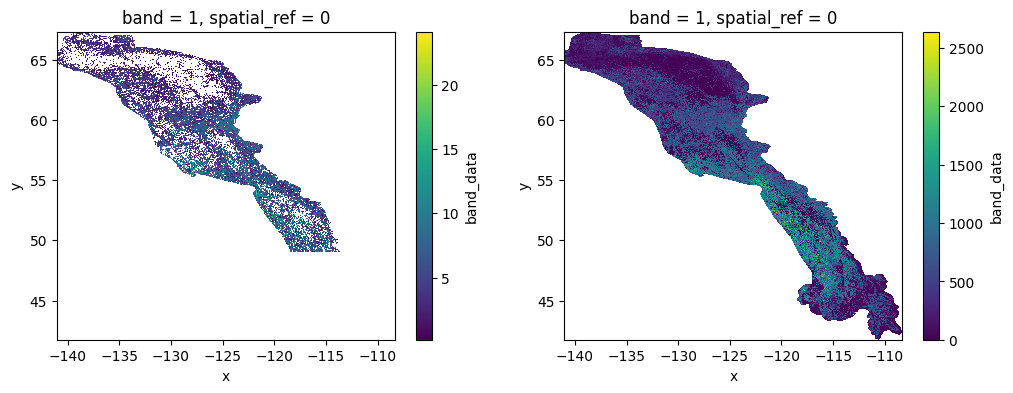

In [9]:
# plot the two
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
carbon_sothe_reproj.plot(ax=axes[0])
carbon_spawn.plot(ax=axes[1])
plt.draw()

In [10]:
# convert sothe to t/ha
carbon_sothe_reproj_t_ha = carbon_sothe_reproj * 10
print_raster(carbon_sothe_reproj_t_ha)

# convert spawn to t/ha
carbon_spawn_t_ha = carbon_spawn * 0.1
print_raster(carbon_spawn_t_ha) 

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 660243968.0
CRS: EPSG:4326
NoDataValue: None
NoDataOriginalValues: None

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1231221504.0
CRS: EPSG:4326
NoDataValue: None
NoDataOriginalValues: None



In [11]:
# combine datasets, defaulting to Sothe values
carbon_t_ha = carbon_sothe_reproj_t_ha.combine_first(carbon_spawn_t_ha)
print_raster(carbon_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1017631680.0
CRS: EPSG:4326
NoDataValue: None
NoDataOriginalValues: None



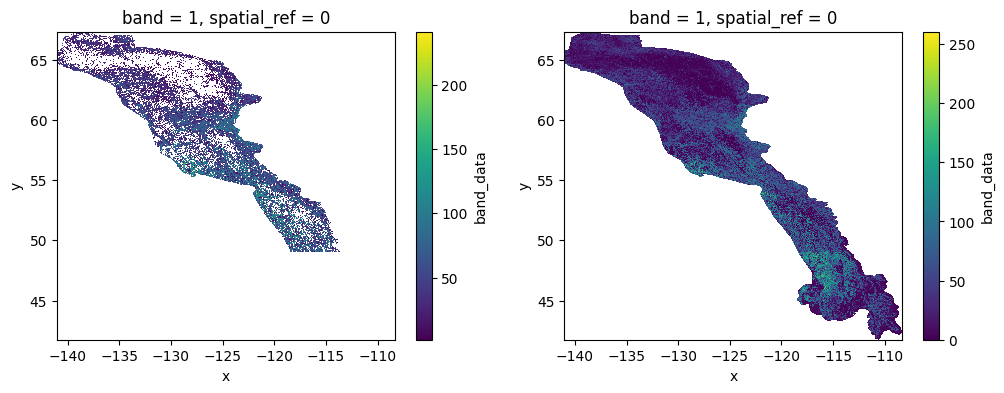

In [12]:
# plot the two
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
carbon_sothe_reproj_t_ha.plot(ax=axes[0])
carbon_t_ha.plot(ax=axes[1])
plt.draw()

In [13]:
# write no data values into metadata
carbon_t_ha.rio.write_nodata(-9999, encoded=True, inplace=True)
print_raster(carbon_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 1017631680.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0



In [14]:
# export raster
carbon_t_ha.rio.to_raster('./carbon_stock_data/output_layers/carbon_sothe_spawn_t_ha.tif')

### The Second map is aboveground and belowground carbon stock from Spawn 2010

In [15]:
# load file path
carbon_dir = './carbon_stock_data/final_layers_clipped'

agb_spawn_dir = carbon_dir + '/agb_mg_ha_spawn_2010.tif'
bgb_spawn_dir = carbon_dir + '/bgb_mg_ha_spawn_2010.tif'

In [16]:
# load data arrays
agb_spawn = xarray.open_dataarray(agb_spawn_dir)
bgb_spawn = xarray.open_dataarray(bgb_spawn_dir)

In [17]:
# check attributes
print_raster(agb_spawn)
print_raster(bgb_spawn)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 8712377344.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 3599774464.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 65536.0



In [18]:
# convert to t/ha
agb_spawn_t_ha = agb_spawn * 0.1
bgb_spawn_t_ha = bgb_spawn * 0.1

In [19]:
# write no data values into metadata
agb_spawn_t_ha.rio.write_nodata(-9999, encoded=True, inplace=True)
bgb_spawn_t_ha.rio.write_nodata(-9999, encoded=True, inplace=True)
print_raster(agb_spawn_t_ha)
print_raster(bgb_spawn_t_ha)

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 871243200.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (9206, 11785)
resolution: (0.002777777777777999, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 359978112.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0



In [20]:
# export final layers
agb_spawn_t_ha.rio.to_raster('./carbon_stock_data/output_layers/agb_c_spawn_t_ha.tif')
bgb_spawn_t_ha.rio.to_raster('./carbon_stock_data/output_layers/bgb_c_spawn_t_ha.tif')

### The Soil Organic Carbon Map is a combination of Sothe Canada data and openlandmap US data 0-1m depth

In [21]:
# load file path
carbon_dir = './carbon_stock_data/final_layers_clipped'

soc_sothe_dir = carbon_dir + '/soc_0_1m_kg_m2_sothe.tif'
soc_olm_dir = carbon_dir + '/soc_0_1m_kg_m2_openlandmap.tif'

In [22]:
# load data arrays
soc_sothe = xarray.open_dataarray(soc_sothe_dir)
soc_olm = xarray.open_dataarray(soc_olm_dir)

In [23]:
# print attributes
print_raster(soc_sothe)
print_raster(soc_olm)

shape: (11386, 14570)
resolution: (0.002245789848076825, -0.0022457903991559692)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 762864064.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 0.0

shape: (12274, 15713)
resolution: (0.0020833330000000006, -0.002083333)
bounds: (-141.035422901, 41.751257299, -108.30001147200001, 67.322086541)
sum: 1455630080.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -32768.0



In [24]:
# reproject olm to match sothe projection and resolution
# resample taking the average
# pixels resampling where 50% or more of samples are nan will be set as nan
soc_olm_reproj = soc_olm.rio.reproject_match(soc_sothe, resampling = Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)

In [25]:
# print attributes
print_raster(soc_sothe)
print_raster(soc_olm_reproj)

shape: (11386, 14570)
resolution: (0.002245789848076825, -0.0022457903991559692)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 762864064.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: 0.0

shape: (11386, 14570)
resolution: (0.0022457898480768247, -0.0022457903991559697)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 1252878720.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -32768.0



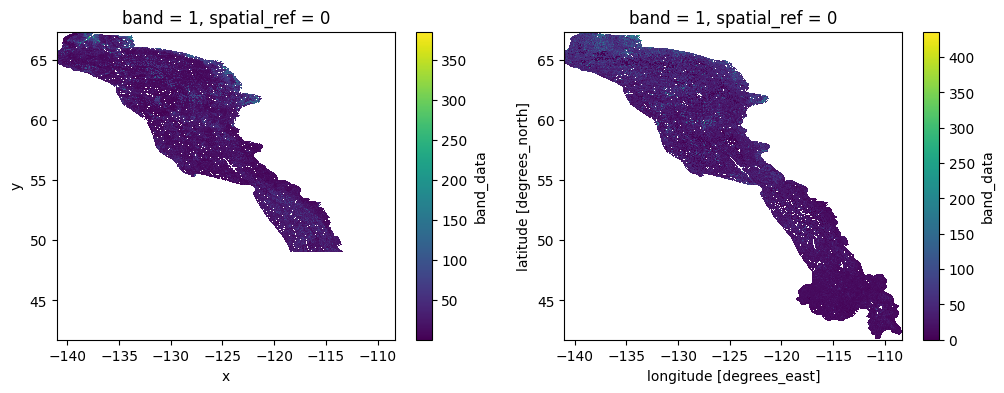

In [26]:
# plot the two
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
soc_sothe.plot(ax=axes[0])
soc_olm_reproj.plot(ax=axes[1])
plt.draw()

In [27]:
# combine datasets, defaulting to Sothe values
soc_0_1m_kg_m2 = soc_sothe.combine_first(soc_olm_reproj)
print_raster(soc_0_1m_kg_m2)

shape: (11386, 14570)
resolution: (0.002245789848076825, -0.0022457903991559692)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 893391808.0
CRS: EPSG:4326
NoDataValue: None
NoDataOriginalValues: None



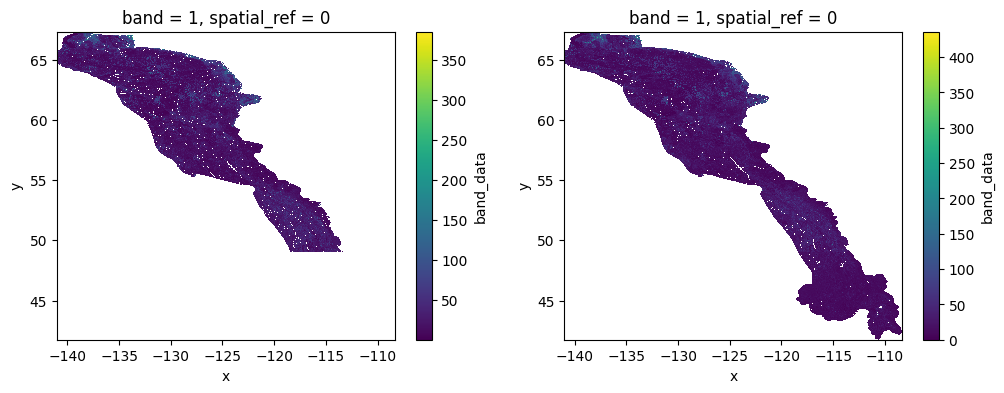

In [28]:
# plot the two
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
soc_sothe.plot(ax=axes[0])
soc_0_1m_kg_m2.plot(ax=axes[1])
plt.draw()

In [29]:
# convert to t/ha
soc_0_1m_t_ha = soc_0_1m_kg_m2 * 10

In [30]:
# write no data values into metadata
soc_0_1m_t_ha.rio.write_nodata(-9999, encoded=True, inplace=True)
print_raster(soc_0_1m_t_ha)

shape: (11386, 14570)
resolution: (0.002245789848076825, -0.0022457903991559692)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 8933918720.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0



In [31]:
# export raster
soc_0_1m_t_ha.rio.to_raster('./carbon_stock_data/output_layers/soc_0_1m_t_ha.tif')